In [1]:
# Peter van Galen, 210820
# This script reproduces Duncan Morgan's analysis of the TCR-Seq data for the MAESTER paper

# Options, clean environment
options(stringsAsFactors = FALSE)
rm(list=ls())

# Environment variables
project <- Sys.getenv('WORKSPACE_NAMESPACE')
workspace <- Sys.getenv('WORKSPACE_NAME')
bucket <- Sys.getenv('WORKSPACE_BUCKET')

# This should already be the working directory but set it just in case
getwd()
setwd('/home/jupyter/notebooks/TCR-Seq_MAESTER/edit')

# Copy data to Google bucket and back
#system(paste0("gsutil cp ~/home/jupyter/notebooks/", workspace, " ", bucket))
system(paste0("gsutil cp ", bucket, "/lane2_barcodes.txt ", " ."))
system(paste0("gsutil cp ", bucket, "/20210805_maester2_TCRalignSortMappingSummary.txt", " ."))

project
workspace
bucket
list.files()

[1] "/home/jupyter/notebooks/TCR-Seq_MAESTER/edit"

[1] "vangalenlab"

[1] "TCR-Seq_MAESTER"

[1] "gs://fc-c1f4ce09-fd0e-48b6-bf60-7b1b555a73b9"

[1] "20210611_maester2_TCRalignSortMappingSummary.txt"
[2] "20210611_maester2_vfilter9.csv"                  
[3] "20210805_maester2_TCRalignSortMappingSummary.txt"
[4] "lane2_barcodes.txt"                              
[5] "maester2_processing.ipynb"                       
[6] "test.ipynb"

In [2]:
barcodes = read.table('lane2_barcodes.txt', stringsAsFactors = FALSE)$V1
head(barcodes)

[1] "ACAACCAGTTAGGCCC" "CAACGGCTCCAATGCA" "CAGCCAGAGACAGCGT" "ACACGCGCAGGATGAC"
[5] "ATCACGACACATCCCT" "GAGCCTGAGATTGATG"

In [3]:
# Load Packages and set Common Parameters ---------------------------------
library(tidyverse)
library(Seurat) %>% suppressMessages()
library(viridis) %>% suppressMessages()
library(RColorBrewer) %>% suppressMessages()
library(dplyr) %>% suppressMessages()
library(data.table) %>% suppressMessages()
library(readr) %>% suppressMessages()
library(stringr) %>% suppressMessages()
library(ggplot2) %>% suppressMessages()

cbPalette <- c("gray87", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [4]:
# Loading files -----------------------------------------------------------
file = '20210805_maester2_TCRalignSortMappingSummary.txt'
TCR_df <- bind_rows(lapply(file, read_tsv)) %>% filter(TopVFreq > .9)
BCSeq = unique(TCR_df$BC)

# Clean & Format ----------------------------------------------------------
#Then let's clean cast some variable into usable formats
TCR_df <- TCR_df %>% mutate(TopVregion = factor(TopVregion), TopJregion = factor(TopJregion))
TCR_df = TCR_df 

#Clean the TCR from umi that gave no CDR3. then orders first by BC, then by nReads within each BC
TCR_df_cleaned <- TCR_df %>% filter(!is.na(CDR3)) %>% arrange(BC, desc(nReads))

#I think there are still several things to do. One is to quantify how many UMI each CDR3 has,
#and then sort the files by UMI, then by reads.

#here we create a second df that records (BC,CDR3) combination and their respective UMI_count
#The unique argument is key here. It prevent double countings
TCR_df_cleaned_UMI_count <- TCR_df_cleaned %>% count(BC, CDR3) %>% rename(UMI_count = n)

#then we make merge the two, grouped by Barcode and CDR3
TCR_df_cleaned<-left_join(TCR_df_cleaned, TCR_df_cleaned_UMI_count, by = c('BC','CDR3')) #%>% arrange(BC, desc(UMI_count),desc(nReads))

#re-order a little bit for readability
TCR_df_cleaned<- TCR_df_cleaned %>% select(UMI_Name,BC,UMI,UMI_count,nReads,everything())

#then re-order the rows again just to make sure the top UMI_count/nReads results are at the top of each 
#cell barcode group.
TCR_df_cleaned<- TCR_df_cleaned[with(TCR_df_cleaned,order(BC,UMI_count,nReads,decreasing=TRUE)),]

#Separate df into alpha and beta chain into two dataframes

TRA_df <- TCR_df_cleaned %>% filter(str_detect(TopVregion, "^TRAV"))
TRB_df <- TCR_df_cleaned %>% filter(str_detect(TopVregion, "^TRBV"))


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  UMI_Name = col_character(),
  BC = col_character(),
  UMI = col_character(),
  TopVregion = col_character(),
  TopJregion = col_character(),
  TopJ_5UTR = col_character(),
  CDR3 = col_character(),
  CDR3nuc = col_character()
)
ℹ Use `spec()` for the full column specifications.




In [5]:
barcodes = data.frame(row.names = BCSeq, BC = BCSeq)

#Then we should generate masks of matching barcodes. We would probably have to do two masks
#Note: these values are just masks that apply to (not BCseq, but) TRA/TRB_df list of values. i.e. it gives
#indices of where in the TRA/TRB_df, do you find the correspoding rank position of the same cell (i.e. first
#position is first cell in the BCSeqlist.)
#BCSeq has to be the total list of barcodes for all of the cells in the Seurat object
is.na(match(BCSeq, TRA_df$BC)) == 0 -> TRA_BC 
is.na(match(BCSeq, TRB_df$BC)) == 0 -> TRB_BC 
TRA_BC & TRB_BC ->TRAB_BC

#is.na(match(BCSeq, TCR_df$BC)) == 0 -> TCR_BC
#is.na(match(BCSeq, TCR_df_cleaned$BC)) == 0 -> TCR_cleaned_BC

#here we construct the mapping necessary to look at mapping statistics 
barcodes$TCR_Recovery <- "No Recovery"
barcodes$TCR_Recovery[c(TRB_BC)] <- "TRB only"
barcodes$TCR_Recovery[c(TRA_BC)] <- "TRA only"
barcodes$TCR_Recovery[c(TRAB_BC)] <- "TRA and TRB"

#Once we get to here, we can do some spot checks. 
#do
#TSNEPlot(umi_seurat, group.by = "TCR_Recovery", colors.use = c(cbPalette), 
# do.hover = TRUE, data.hover = "ident")
#and look at specific points, and find their cell identity name
#then do: BCSeq[match("cellname",names(umi_seurat@ident))]
#to find teh particular barcode, then we could check to see if that barcode actually exist in our TCR data
#VlnPlot(umi_seurat,c("TRBC2", "TRAC"), group.by = "TCR_Recovery")

barcodes$TRB_CDR3 <- "No Recovery"
barcodes$TRB_CDR3 <- TRB_df$CDR3[match(BCSeq,TRB_df$BC)]
barcodes$TRB_CDR3nuc <- TRB_df$CDR3nuc[match(BCSeq,TRB_df$BC)]

barcodes$TRBV <- TRB_df$TopVregion[match(BCSeq,TRB_df$BC)]
barcodes$TRBJ<- TRB_df$TopJregion[match(BCSeq,TRB_df$BC)]


#checked and the data seems to make sense
#The problem here is that this only gives us one TRA, but we should look at multiple. 

#First we get rid of the duplicates of the TRA, because in a lot of importing of data, we are importing 
#duplicated data since the same sample could be sequenced multiple times, etc. 

TRA_df %>% distinct(BC,CDR3,TopVregion, .keep_all = TRUE) -> TRA_uniq_df

match(BCSeq,TRA_uniq_df$BC) -> TRA1_Match

barcodes$TRA_CDR3 <- "No Recovery"
barcodes$TRA_CDR3 <- TRA_uniq_df$CDR3[TRA1_Match]
barcodes$TRAV <- TRA_uniq_df$TopVregion[TRA1_Match]
barcodes$TRAJ<- TRA_uniq_df$TopJregion[TRA1_Match]
barcodes$TRA_CDR3nuc<- TRA_uniq_df$CDR3nuc[TRA1_Match]

#then we remove the rows that we just assigned 
TRA1_Match_filter <- TRA1_Match[!is.na(TRA1_Match)]
TRA2_uniq_df <- TRA_uniq_df[-TRA1_Match_filter, ]

match(BCSeq,TRA2_uniq_df$BC) -> TRA2_Match

barcodes$TRA.2_CDR3 <- NA
barcodes$TRA.2_CDR3 <- TRA2_uniq_df$CDR3[TRA2_Match]
barcodes$TRAV.2 <- TRA2_uniq_df$TopVregion[TRA2_Match]
barcodes$TRAJ.2<- TRA2_uniq_df$TopJregion[TRA2_Match]
barcodes$TRA.2_CDR3nuc <- TRA2_uniq_df$CDR3nuc[TRA2_Match]


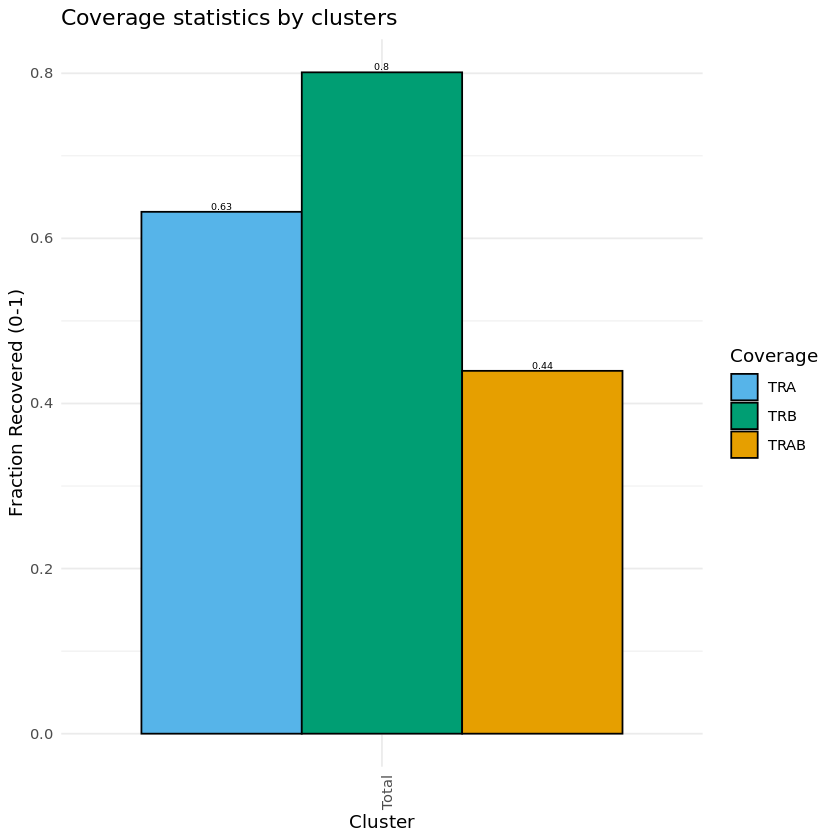

In [6]:
# Calculate Coverage Statistics -------------------------------------------

#now we should generate more graphs automatically. Here we first generate data about coverage statistics

cell_ident_df <- data.frame(name =barcodes$Barcode, ident = (barcodes$Array))
rownames(cell_ident_df) <- c()

#then generate the list of identities previously identified by Seurat
ident_list <- levels(factor(barcodes$Array))

#then I think we iteratively look through TRA, TRB, TRA and TRB statistics using for loops
TRA_stat <- c()
TRB_stat <- c()
TRAB_stat <- c()
for (i in ident_list){
  is.na(match(cell_ident_df$ident, i)) == 0 -> mask
  sub_total <- sum(mask)
  TRA_stat <- c(TRA_stat, sum(TRA_BC[c(mask)])/sub_total)
  TRB_stat <- c(TRB_stat, sum(TRB_BC[c(mask)])/sub_total)
  TRAB_stat <- c(TRAB_stat, sum(TRAB_BC[c(mask)])/sub_total)
}
#After iterating through the specific cluster list, do one last iteration to get the total stat

ident_list <- c(ident_list,"Total")
TRA_stat <- c(TRA_stat, sum(TRA_BC)/length(TRA_BC))
TRB_stat <- c(TRB_stat, sum(TRB_BC)/length(TRB_BC))
TRAB_stat <- c(TRAB_stat, sum(TRAB_BC)/length(TRAB_BC))

Coverage_summary_df <- data.frame(Cluster = ident_list,TRA = TRA_stat,TRB = TRB_stat,TRAB = TRAB_stat)

#Then we need to create plot based on teh dat that we did

Coverage_summary_long<-reshape2::melt(Coverage_summary_df,id.vars="Cluster")

Coverage_bar <- ggplot(data = Coverage_summary_long, aes(x = Cluster, y = value, fill = variable)) +
  geom_bar(stat = "identity",position="dodge", color = "black") + scale_x_discrete(limits = ident_list) +
  scale_fill_manual("Coverage", values = c("TRA" = cbPalette[3], "TRB" = cbPalette[4], "TRAB" = cbPalette[2])) +
  labs(title = "Coverage statistics by clusters", y = "Fraction Recovered (0-1)") + 
  geom_text(aes(label = round(value,digits = 2)),vjust = -0.3, size = 2,position = position_dodge(width=0.9)) +
  theme_minimal() + theme(axis.text.x = element_text(angle = 90))

#pdf("TCR_coverage_by_cluster.pdf", width = 11, height = 8)
Coverage_bar
#dev.off()

In [8]:
# Save results
write.csv(barcodes, '20210805_maester2_vfilter9.csv')

# Copy to Google bucket (for longer term storage)
#system(paste0("gsutil cp 20210805_maester2_vfilter9.csv ", bucket))